# Run interventions in loop with OpenABM 

In [1]:
import sys
sys.path.insert(0,'./src/')
sib_folder = "../sib" # sib path
abm_folder = "../OpenABM-Covid19/src" #Open ABM path
sys.path.insert(0,sib_folder)
sys.path.insert(0,abm_folder)
from pathlib import Path
import log, logging
from importlib import reload
import loop_abm, abm_utils, scipy

#logging
output_dir = "./output/"
fold_out = Path(output_dir)
if not fold_out.exists():
    fold_out.mkdir(parents=True)

reload(log)
logger = log.setup_logger()

num_threads = 40 #number of threads used for sib 

Log setup complete


## Epidemic model

#### Set the parameters of the OpenABM foward simulation

In [2]:
N=50000 #Number of individuals
T=100 #Total time of simulations
seed = 1 #seed of the random number generator
n_seed_infection = 10 #number of patient zero

params_model = {
    "rng_seed" : seed,
    "end_time" : T,
    "n_total"  : N,
    "days_of_interactions" : T,
    "n_seed_infection" : n_seed_infection,
}

## Set testing and quarantine rules

In [3]:
fraction_SM_obs = 0.5 #fraction of Symptomatic Mild tested positive
fraction_SS_obs = 1 #fraction of Symptomatic Severe tested positive
initial_steps = 12 #starting time of intervention
quarantine_HH = True #Households quarantine
test_HH = True #Tests the households when quarantined
adoption_fraction = 1 #app adoption (fraction)
num_test_random = 0 #number of random tests per day
num_test_algo = 200 #number of tests using by the ranker per day
fp_rate = 0.0 #test false-positive rate
fn_rate = 0.0 #test false-negative rate

## Choose the rankers algorithms class

In [4]:
from rankers import dotd_rank, tracing_rank, mean_field_rank, sib_rank
import sib


prob_seed = 1/N
prob_sus = 0.55
pseed = prob_seed / (2 - prob_seed)
psus = prob_sus * (1 - pseed)
pautoinf = 1/N


dotd = dotd_rank.DotdRanker()

tracing = tracing_rank.TracingRanker(
                 tau=5,
                 lamb=0.014
)

MF = mean_field_rank.MeanFieldRanker(
                tau = 5,
                delta = 10,
                mu = 1/30,
                lamb = 0.014
                )

sib.set_num_threads(num_threads)
sib_ranker = sib_rank.SibRanker(
                 params = sib.Params(
                                 # faster implementation
                                 #prob_i = sib.Cached(sib.Scaled(sib.PDF(sib.Gamma(k=5.76, mu=0.96)), scale=0.25), T+1),
                                 #prob_r = sib.Cached(sib.Gamma(k = 10, mu = 1/1.7452974337097158), T+1),
                                 prob_i = sib.PiecewiseLinear(sib.RealParams(list(0.25*abm_utils.gamma_pdf_array(T+1,6,2.5)))),
                                 prob_r = sib.PiecewiseLinear(sib.RealParams(list(scipy.stats.gamma.sf(range(T+1), 10., scale=1.7452974337097158)))),
                                 pseed = pseed,
                                 psus = psus,
                                 fp_rate = fp_rate,
                                 fn_rate = fn_rate,
                                 pautoinf = pautoinf),
                 maxit0 = 20,
                 maxit1 = 20,
                 tol = 1e-3,
                 memory_decay = 1e-5,
                 window_length = 21,
                 tau=7
)


ress = {}


In [5]:
rankers = {
    "RG" : dotd,
    "CT": tracing,
    "SMF" : MF,
    "BP": sib_ranker,
} 

### Set up figure

In [6]:
%matplotlib widget
import matplotlib.pyplot as plt
import plot_utils
import time

plots = plot_utils.plot_style(N, T)
save_path_fig = f"./output/plot_run_N_{N}_SM_{fraction_SM_obs}_test_{num_test_algo}_n_seed_infection_{n_seed_infection}_seed_{seed}_fp_{fp_rate}_fn_{fn_rate}.png"
fig, callback = plot_utils.plotgrid(rankers, plots, initial_steps, save_path=save_path_fig)
time.sleep(0.5)
fig.canvas

Canvas(header_visible=False, toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Bac…

In [7]:
import imp 
imp.reload(loop_abm)

for s in rankers:
    data = {"algo":s}
    loop_abm.loop_abm(
        params_model, 
        rankers[s], 
        seed=seed, 
        logger = logging.getLogger(f"iteration.{s}"), 
        data = data, 
        callback = callback,
        initial_steps = initial_steps, 
        num_test_random = num_test_random,
        num_test_algo = num_test_algo,
        fraction_SM_obs = fraction_SM_obs,
        fraction_SS_obs = fraction_SS_obs,
        quarantine_HH = quarantine_HH,
        test_HH = test_HH,
        adoption_fraction = adoption_fraction,
        fp_rate = fp_rate,
        fn_rate = fn_rate,
        name_file_res = s + f"_N_{N}_T_{T}_obs_{num_test_algo}_SM_obs_{fraction_SM_obs}_seed_{seed}"
    )
    ress[s] = data
    # saves a bit of memory: rankers[s] = {}

COVID19.model: INFO     Returning self.c_params into Model object, future updates to parameters not possible
COVID19.model: INFO     Started model creation
COVID19.model: INFO     Successfuly created model
COVID19.model: INFO     Started model creation
COVID19.model: INFO     Successfuly created model
iteration.RG: INFO     time:0
iteration.RG: INFO     number of unique contacts: 632210
iteration.RG: INFO     True  : (S,I,R): (49990.0, 10.0, 0.0)
iteration.RG: INFO     AUR_I : 0.608, prec(1% of 50001): 0.00, prec5%: 0.00
iteration.RG: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.RG: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.RG: INFO     ...quarantining 0 guys -> got 0 infected, 10 free as birds (+10)
iteration.RG: INFO     time:1
iteration.RG: INFO     number of unique contacts: 632414
iteration.RG: INFO     True  : (S,I,R): (49988.0, 12.0, 0.0)
iteration.RG: INFO     AUR_I : 0.387, prec(1% of 50001): 0.00, prec5%: 0.00
iteratio

sib.iterate(damp=0):  2/20 2.368e-07/0.001    
sib.iterate(damp=0.5):  0/20 7.297e-10/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49999.1, 0.9, 0.0), seeds: 0.9, ll: -29891.6
iteration.BP: INFO     True  : (S,I,R): (49990.0, 10.0, 0.0)
iteration.BP: INFO     AUR_I : 0.426, prec(1% of 50001): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 10 free as birds (+10)
iteration.BP: INFO     time:1
iteration.BP: INFO     number of unique contacts: 632414


sib.iterate(damp=0):  2/20 3.025e-06/0.001    
sib.iterate(damp=0.5):  0/20 9.782e-08/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49998.3, 1.7, 0.0), seeds: 0.9, ll: -29891.8
iteration.BP: INFO     True  : (S,I,R): (49988.0, 12.0, 0.0)
iteration.BP: INFO     AUR_I : 0.353, prec(1% of 50001): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 7 guys -> got 3 infected, 9 free as birds (-1)
iteration.BP: INFO     time:2
iteration.BP: INFO     number of unique contacts: 632688


sib.iterate(damp=0):  2/20 1.200e-05/0.001    
sib.iterate(damp=0.5):  0/20 1.086e-06/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49997.4, 2.6, 0.0), seeds: 0.8, ll: -29892.3
iteration.BP: INFO     True  : (S,I,R): (49983.0, 17.0, 0.0)
iteration.BP: INFO     AUR_I : 0.591, prec(1% of 49994): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 14 free as birds (+5)
iteration.BP: INFO     time:3
iteration.BP: INFO     number of unique contacts: 632572


sib.iterate(damp=0):  2/20 3.040e-05/0.001    
sib.iterate(damp=0.5):  0/20 5.135e-06/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49996.5, 3.5, 0.0), seeds: 0.8, ll: -29895.6
iteration.BP: INFO     True  : (S,I,R): (49980.0, 20.0, 0.0)
iteration.BP: INFO     AUR_I : 0.680, prec(1% of 49994): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 3 guys -> got 1 infected, 16 free as birds (+2)
iteration.BP: INFO     time:4
iteration.BP: INFO     number of unique contacts: 632250


sib.iterate(damp=0):  2/20 7.774e-05/0.001    
sib.iterate(damp=0.5):  0/20 1.521e-05/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49995.4, 4.6, 0.0), seeds: 0.7, ll: -29917.4
iteration.BP: INFO     True  : (S,I,R): (49972.0, 28.0, 0.0)
iteration.BP: INFO     AUR_I : 0.624, prec(1% of 49991): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 5 guys -> got 2 infected, 21 free as birds (+5)
iteration.BP: INFO     time:5
iteration.BP: INFO     number of unique contacts: 632788


sib.iterate(damp=0):  2/20 1.112e-04/0.001    
sib.iterate(damp=0.5):  0/20 2.958e-05/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49994.1, 5.9, 0.0), seeds: 0.6, ll: -29997.2
iteration.BP: INFO     True  : (S,I,R): (49970.0, 30.0, 0.0)
iteration.BP: INFO     AUR_I : 0.599, prec(1% of 49986): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 3 guys -> got 1 infected, 22 free as birds (+1)
iteration.BP: INFO     time:6
iteration.BP: INFO     number of unique contacts: 632666


sib.iterate(damp=0):  2/20 2.073e-04/0.001    
sib.iterate(damp=0.5):  0/20 5.926e-05/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49992.8, 7.2, 0.0), seeds: 0.5, ll: -30193.3
iteration.BP: INFO     True  : (S,I,R): (49964.0, 36.0, 0.0)
iteration.BP: INFO     AUR_I : 0.574, prec(1% of 49983): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 28 free as birds (+6)
iteration.BP: INFO     time:7
iteration.BP: INFO     number of unique contacts: 631766


sib.iterate(damp=0):  2/20 1.968e-04/0.001    
sib.iterate(damp=0.5):  0/20 9.633e-05/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49991.4, 8.6, 0.0), seeds: 0.5, ll: -30547.7
iteration.BP: INFO     True  : (S,I,R): (49956.0, 44.0, 0.0)
iteration.BP: INFO     AUR_I : 0.561, prec(1% of 49983): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 2 guys -> got 2 infected, 32 free as birds (+4)
iteration.BP: INFO     time:8
iteration.BP: INFO     number of unique contacts: 631494


sib.iterate(damp=0):  2/20 2.770e-04/0.001    
sib.iterate(damp=0.5):  0/20 1.344e-04/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49990.0, 9.9, 0.0), seeds: 0.4, ll: -31078.1
iteration.BP: INFO     True  : (S,I,R): (49945.0, 54.0, 1.0)
iteration.BP: INFO     AUR_I : 0.573, prec(1% of 49981): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 3 guys -> got 2 infected, 41 free as birds (+9)
iteration.BP: INFO     time:9
iteration.BP: INFO     number of unique contacts: 631900


sib.iterate(damp=0):  2/20 3.106e-04/0.001    
sib.iterate(damp=0.5):  0/20 1.821e-04/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49988.7, 11.2, 0.1), seeds: 0.4, ll: -31773.6
iteration.BP: INFO     True  : (S,I,R): (49934.0, 65.0, 1.0)
iteration.BP: INFO     AUR_I : 0.605, prec(1% of 49978): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 52 free as birds (+11)
iteration.BP: INFO     time:10
iteration.BP: INFO     number of unique contacts: 632824


sib.iterate(damp=0):  2/20 4.472e-04/0.001    
sib.iterate(damp=0.5):  0/20 2.239e-04/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49987.5, 12.4, 0.1), seeds: 0.3, ll: -32549.1
iteration.BP: INFO     True  : (S,I,R): (49926.0, 73.0, 1.0)
iteration.BP: INFO     AUR_I : 0.602, prec(1% of 49978): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 8 guys -> got 6 infected, 54 free as birds (+2)
iteration.BP: INFO     time:11
iteration.BP: INFO     number of unique contacts: 631306


sib.iterate(damp=0):  2/20 4.333e-04/0.001    
sib.iterate(damp=0.5):  0/20 2.910e-04/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49986.3, 13.5, 0.1), seeds: 0.3, ll: -33396.5
iteration.BP: INFO     True  : (S,I,R): (49913.0, 86.0, 1.0)
iteration.BP: INFO     AUR_I : 0.586, prec(1% of 49970): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 5 guys -> got 2 infected, 65 free as birds (+11)
iteration.BP: INFO     
observation-based inference algorithm starts now

iteration.BP: INFO     time:12
iteration.BP: INFO     number of unique contacts: 632968


sib.iterate(damp=0):  19/20 9.944e-01/0.001        
sib.iterate(damp=0.5):  19/20 1.496e-01/0.001            


iteration.BP: INFO     winBP: (S,I,R): (49979.1, 20.7, 0.2), seeds: 0.3, ll: -29832.8
iteration.BP: INFO     True  : (S,I,R): (49897.0, 101.0, 2.0)
iteration.BP: INFO     AUR_I : 0.584, prec(1% of 49954): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 1, results test algo (S,I,R): (196,4,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 15 guys -> got 7 infected, 73 free as birds (+8)
iteration.BP: INFO     time:13
iteration.BP: INFO     number of unique contacts: 632072


sib.iterate(damp=0):  19/20 2.793e-01/0.001               
sib.iterate(damp=0.5):  19/20 2.554e-02/0.001        


iteration.BP: INFO     winBP: (S,I,R): (49970.0, 29.6, 0.4), seeds: 0.6, ll: -29960.7
iteration.BP: INFO     True  : (S,I,R): (49882.0, 113.0, 5.0)
iteration.BP: INFO     AUR_I : 0.575, prec(1% of 49939): 0.01, prec5%: 0.00
iteration.BP: INFO     SS: 3, SM: 2, results test algo (S,I,R): (197,3,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 25 guys -> got 11 infected, 76 free as birds (+3)
iteration.BP: INFO     time:14
iteration.BP: INFO     number of unique contacts: 630192


sib.iterate(damp=0):  19/20 9.988e-01/0.001                   
sib.iterate(damp=0.5):  19/20 1.296e-01/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49948.4, 50.7, 0.9), seeds: 0.8, ll: -29278.2
iteration.BP: INFO     True  : (S,I,R): (49868.0, 126.0, 6.0)
iteration.BP: INFO     AUR_I : 0.660, prec(1% of 49886): 0.01, prec5%: 0.01
iteration.BP: INFO     SS: 0, SM: 2, results test algo (S,I,R): (185,14,1), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 45 guys -> got 21 infected, 68 free as birds (-8)
iteration.BP: INFO     time:15
iteration.BP: INFO     number of unique contacts: 630526


sib.iterate(damp=0):  19/20 4.052e-01/0.001           
sib.iterate(damp=0.5):  19/20 5.854e-01/0.001        


iteration.BP: INFO     winBP: (S,I,R): (49914.8, 80.9, 4.2), seeds: 2.1, ll: -29965.6
iteration.BP: INFO     True  : (S,I,R): (49847.0, 145.0, 8.0)
iteration.BP: INFO     AUR_I : 0.672, prec(1% of 49850): 0.02, prec5%: 0.01
iteration.BP: INFO     SS: 4, SM: 1, results test algo (S,I,R): (187,13,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 45 guys -> got 21 infected, 66 free as birds (-2)
iteration.BP: INFO     time:16
iteration.BP: INFO     number of unique contacts: 628458


sib.iterate(damp=0):  19/20 9.130e-01/0.001               
sib.iterate(damp=0.5):  19/20 7.241e-01/0.001                   


iteration.BP: INFO     winBP: (S,I,R): (49883.8, 110.4, 5.8), seeds: 2.3, ll: -29844.1
iteration.BP: INFO     True  : (S,I,R): (49826.0, 164.0, 10.0)
iteration.BP: INFO     AUR_I : 0.773, prec(1% of 49783): 0.01, prec5%: 0.01
iteration.BP: INFO     SS: 0, SM: 1, results test algo (S,I,R): (179,21,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 57 guys -> got 27 infected, 55 free as birds (-11)
iteration.BP: INFO     time:17
iteration.BP: INFO     number of unique contacts: 628600


sib.iterate(damp=0):  19/20 5.156e-01/0.001    
sib.iterate(damp=0.5):  19/20 1.149e-01/0.001               


iteration.BP: INFO     winBP: (S,I,R): (49848.6, 144.6, 6.7), seeds: 1.9, ll: -29954.3
iteration.BP: INFO     True  : (S,I,R): (49810.0, 172.0, 18.0)
iteration.BP: INFO     AUR_I : 0.710, prec(1% of 49750): 0.01, prec5%: 0.01
iteration.BP: INFO     SS: 0, SM: 2, results test algo (S,I,R): (192,8,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 34 guys -> got 10 infected, 57 free as birds (+2)
iteration.BP: INFO     time:18
iteration.BP: INFO     number of unique contacts: 627638


sib.iterate(damp=0):  19/20 9.519e-01/0.001               
sib.iterate(damp=0.5):  19/20 7.749e-02/0.001            


iteration.BP: INFO     winBP: (S,I,R): (49838.5, 152.6, 8.9), seeds: 1.8, ll: -30045.3
iteration.BP: INFO     True  : (S,I,R): (49790.0, 189.0, 21.0)
iteration.BP: INFO     AUR_I : 0.688, prec(1% of 49728): 0.00, prec5%: 0.01
iteration.BP: INFO     SS: 1, SM: 1, results test algo (S,I,R): (195,5,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 20 guys -> got 8 infected, 63 free as birds (+6)
iteration.BP: INFO     time:19
iteration.BP: INFO     number of unique contacts: 627590


sib.iterate(damp=0):  19/20 9.898e-01/0.001           
sib.iterate(damp=0.5):  19/20 5.878e-01/0.001                       


iteration.BP: INFO     winBP: (S,I,R): (49806.9, 179.7, 13.4), seeds: 2.5, ll: -30901.9
iteration.BP: INFO     True  : (S,I,R): (49773.0, 201.0, 26.0)
iteration.BP: INFO     AUR_I : 0.700, prec(1% of 49703): 0.01, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 0, results test algo (S,I,R): (193,7,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 25 guys -> got 12 infected, 62 free as birds (-1)
iteration.BP: INFO     time:20
iteration.BP: INFO     number of unique contacts: 627566


sib.iterate(damp=0):  19/20 4.797e-01/0.001               
sib.iterate(damp=0.5):  19/20 4.516e-02/0.001               


iteration.BP: INFO     winBP: (S,I,R): (49806.9, 177.3, 15.8), seeds: 2.1, ll: -30332.1
iteration.BP: INFO     True  : (S,I,R): (49759.0, 211.0, 30.0)
iteration.BP: INFO     AUR_I : 0.727, prec(1% of 49659): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (187,13,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 39 guys -> got 15 infected, 57 free as birds (-5)
iteration.BP: INFO     time:21
iteration.BP: INFO     number of unique contacts: 625682


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 0.906998168296915
sib.iterate(damp=0):  19/20 8.651e-01/0.001                   
sib.iterate(damp=0.5):  19/20 1.052e-01/0.001                   


iteration.BP: INFO     winBP: (S,I,R): (49787.6, 192.6, 19.9), seeds: 2.5, ll: -50720.0
iteration.BP: INFO     True  : (S,I,R): (49746.0, 214.0, 40.0)
iteration.BP: INFO     AUR_I : 0.701, prec(1% of 49648): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (195,5,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 11 guys -> got 7 infected, 58 free as birds (+1)
iteration.BP: INFO     time:22
iteration.BP: INFO     number of unique contacts: 626414


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.7110155132481477
sib.iterate(damp=0):  19/20 9.088e-01/0.001    
sib.iterate(damp=0.5):  19/20 8.792e-02/0.001       


iteration.BP: INFO     winBP: (S,I,R): (49777.1, 198.4, 24.5), seeds: 3.4, ll: -50667.5
iteration.BP: INFO     True  : (S,I,R): (49732.0, 221.0, 47.0)
iteration.BP: INFO     AUR_I : 0.671, prec(1% of 49636): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 2, SM: 1, results test algo (S,I,R): (195,5,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 20 guys -> got 9 infected, 60 free as birds (+2)
iteration.BP: INFO     time:23
iteration.BP: INFO     number of unique contacts: 625260


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 2.5508962765587495
sib.iterate(damp=0):  19/20 9.936e-01/0.001               
sib.iterate(damp=0.5):  19/20 4.494e-01/0.001        


iteration.BP: INFO     winBP: (S,I,R): (49729.0, 238.1, 32.9), seeds: 5.6, ll: -51610.9
iteration.BP: INFO     True  : (S,I,R): (49720.0, 229.0, 51.0)
iteration.BP: INFO     AUR_I : 0.682, prec(1% of 49604): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 0, results test algo (S,I,R): (190,10,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 26 guys -> got 12 infected, 55 free as birds (-5)
iteration.BP: INFO     time:24
iteration.BP: INFO     number of unique contacts: 625192


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 3.513903061250593
sib.iterate(damp=0):  19/20 2.801e-01/0.001    
sib.iterate(damp=0.5):  19/20 9.488e-03/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49741.1, 222.1, 36.7), seeds: 6.1, ll: -50805.7
iteration.BP: INFO     True  : (S,I,R): (49699.0, 241.0, 60.0)
iteration.BP: INFO     AUR_I : 0.685, prec(1% of 49589): 0.01, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (193,7,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 13 guys -> got 8 infected, 59 free as birds (+4)
iteration.BP: INFO     time:25
iteration.BP: INFO     number of unique contacts: 624316


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 4.633869516818728
sib.iterate(damp=0):  19/20 5.932e-02/0.001        
sib.iterate(damp=0.5):  15/20 6.427e-04/0.001           


iteration.BP: INFO     winBP: (S,I,R): (49733.3, 223.9, 42.9), seeds: 8.6, ll: -50843.0
iteration.BP: INFO     True  : (S,I,R): (49685.0, 244.0, 71.0)
iteration.BP: INFO     AUR_I : 0.664, prec(1% of 49580): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 1, results test algo (S,I,R): (194,5,1), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 14 guys -> got 9 infected, 59 free as birds (+0)
iteration.BP: INFO     time:26
iteration.BP: INFO     number of unique contacts: 624748


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 5.882453165820756
sib.iterate(damp=0):  19/20 9.956e-01/0.001    
sib.iterate(damp=0.5):  19/20 3.949e-01/0.001               


iteration.BP: INFO     winBP: (S,I,R): (49694.5, 251.6, 53.9), seeds: 10.5, ll: -51092.2
iteration.BP: INFO     True  : (S,I,R): (49667.0, 254.0, 79.0)
iteration.BP: INFO     AUR_I : 0.690, prec(1% of 49565): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 3, SM: 2, results test algo (S,I,R): (197,3,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 20 guys -> got 12 infected, 58 free as birds (-1)
iteration.BP: INFO     time:27
iteration.BP: INFO     number of unique contacts: 624382


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 7.2132862951372765
sib.iterate(damp=0):  19/20 9.854e-01/0.001       
sib.iterate(damp=0.5):  19/20 2.487e-01/0.001           


iteration.BP: INFO     winBP: (S,I,R): (49674.9, 260.3, 64.8), seeds: 13.2, ll: -50969.5
iteration.BP: INFO     True  : (S,I,R): (49648.0, 263.0, 89.0)
iteration.BP: INFO     AUR_I : 0.802, prec(1% of 49492): 0.01, prec5%: 0.01
iteration.BP: INFO     SS: 1, SM: 0, results test algo (S,I,R): (181,18,1), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 64 guys -> got 27 infected, 47 free as birds (-11)
iteration.BP: INFO     time:28
iteration.BP: INFO     number of unique contacts: 623728


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 8.574741338637986
sib.iterate(damp=0):  19/20 4.824e-02/0.001                   
sib.iterate(damp=0.5):  19/20 1.665e-03/0.001                   


iteration.BP: INFO     winBP: (S,I,R): (49640.9, 283.2, 75.9), seeds: 17.0, ll: -51058.2
iteration.BP: INFO     True  : (S,I,R): (49635.0, 266.0, 99.0)
iteration.BP: INFO     AUR_I : 0.851, prec(1% of 49464): 0.02, prec5%: 0.01
iteration.BP: INFO     SS: 2, SM: 1, results test algo (S,I,R): (191,8,1), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 31 guys -> got 13 infected, 40 free as birds (-7)
iteration.BP: INFO     time:29
iteration.BP: INFO     number of unique contacts: 622924


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 9.9288094444373
sib.iterate(damp=0):  19/20 8.321e-01/0.001           
sib.iterate(damp=0.5):  19/20 9.086e-02/0.001            


iteration.BP: INFO     winBP: (S,I,R): (49624.9, 285.6, 89.6), seeds: 22.6, ll: -50986.7
iteration.BP: INFO     True  : (S,I,R): (49626.0, 261.0, 113.0)
iteration.BP: INFO     AUR_I : 0.835, prec(1% of 49436): 0.01, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 0, results test algo (S,I,R): (192,8,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 24 guys -> got 11 infected, 35 free as birds (-5)
iteration.BP: INFO     time:30
iteration.BP: INFO     number of unique contacts: 621928


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 11.236726264096218
sib.iterate(damp=0):  19/20 1.974e-02/0.001                   
sib.iterate(damp=0.5):  5/20 7.829e-04/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49607.6, 288.4, 104.0), seeds: 27.7, ll: -51176.3
iteration.BP: INFO     True  : (S,I,R): (49609.0, 267.0, 124.0)
iteration.BP: INFO     AUR_I : 0.768, prec(1% of 49404): 0.01, prec5%: 0.00
iteration.BP: INFO     SS: 2, SM: 3, results test algo (S,I,R): (190,10,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 47 guys -> got 18 infected, 28 free as birds (-7)
iteration.BP: INFO     time:31
iteration.BP: INFO     number of unique contacts: 621956


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 12.440533082910033
sib.iterate(damp=0):  19/20 8.952e-01/0.001           
sib.iterate(damp=0.5):  19/20 5.391e-02/0.001                       


iteration.BP: INFO     winBP: (S,I,R): (49576.9, 305.1, 118.0), seeds: 32.2, ll: -51226.4
iteration.BP: INFO     True  : (S,I,R): (49598.0, 257.0, 145.0)
iteration.BP: INFO     AUR_I : 0.761, prec(1% of 49373): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 2, results test algo (S,I,R): (194,6,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 18 guys -> got 9 infected, 22 free as birds (-6)
iteration.BP: INFO     time:32
iteration.BP: INFO     number of unique contacts: 620718


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 13.528987893412223
sib.iterate(damp=0):  19/20 7.041e-01/0.001    
sib.iterate(damp=0.5):  19/20 8.380e-02/0.001               


iteration.BP: INFO     winBP: (S,I,R): (49566.3, 303.1, 130.7), seeds: 43.9, ll: -51277.3
iteration.BP: INFO     True  : (S,I,R): (49590.0, 254.0, 156.0)
iteration.BP: INFO     AUR_I : 0.721, prec(1% of 49357): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (193,6,1), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 11 guys -> got 6 infected, 21 free as birds (-1)
iteration.BP: INFO     time:33
iteration.BP: INFO     number of unique contacts: 620918


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 20.708281485109314
sib.iterate(damp=0):  19/20 3.636e-01/0.001               
sib.iterate(damp=0.5):  19/20 1.998e-02/0.001                       


iteration.BP: INFO     winBP: (S,I,R): (49572.4, 287.5, 140.2), seeds: 51.8, ll: -51364.7
iteration.BP: INFO     True  : (S,I,R): (49581.0, 247.0, 172.0)
iteration.BP: INFO     AUR_I : 0.687, prec(1% of 49356): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 25 free as birds (+4)
iteration.BP: INFO     time:34
iteration.BP: INFO     number of unique contacts: 620992


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 29.560785907647503
sib.iterate(damp=0):  19/20 2.924e-01/0.001    
sib.iterate(damp=0.5):  19/20 1.230e-02/0.001                


iteration.BP: INFO     winBP: (S,I,R): (49591.0, 262.7, 146.3), seeds: 65.4, ll: -51392.1
iteration.BP: INFO     True  : (S,I,R): (49571.0, 247.0, 182.0)
iteration.BP: INFO     AUR_I : 0.645, prec(1% of 49356): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 1, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 7 guys -> got 3 infected, 25 free as birds (+0)
iteration.BP: INFO     time:35
iteration.BP: INFO     number of unique contacts: 621560


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 50.66413176469213
sib.iterate(damp=0):  19/20 1.071e-01/0.001    
sib.iterate(damp=0.5):  19/20 9.389e-04/0.001                   


iteration.BP: INFO     winBP: (S,I,R): (49601.8, 249.9, 148.3), seeds: 71.0, ll: -51237.3
iteration.BP: INFO     True  : (S,I,R): (49550.0, 249.0, 201.0)
iteration.BP: INFO     AUR_I : 0.718, prec(1% of 49336): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 0, results test algo (S,I,R): (191,9,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 18 guys -> got 12 infected, 26 free as birds (+1)
iteration.BP: INFO     time:36
iteration.BP: INFO     number of unique contacts: 620638


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 80.93920089177419
sib.iterate(damp=0):  19/20 7.138e-02/0.001           
sib.iterate(damp=0.5):  19/20 2.207e-03/0.001               


iteration.BP: INFO     winBP: (S,I,R): (49607.5, 240.5, 151.9), seeds: 86.0, ll: -51192.1
iteration.BP: INFO     True  : (S,I,R): (49538.0, 254.0, 208.0)
iteration.BP: INFO     AUR_I : 0.695, prec(1% of 49319): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (196,4,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 12 guys -> got 5 infected, 31 free as birds (+5)
iteration.BP: INFO     time:37
iteration.BP: INFO     number of unique contacts: 619804


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 110.37318986040174
sib.iterate(damp=0):  19/20 1.507e-02/0.001            
sib.iterate(damp=0.5):  13/20 8.493e-04/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49629.4, 221.3, 149.2), seeds: 86.7, ll: -51024.1
iteration.BP: INFO     True  : (S,I,R): (49531.0, 246.0, 223.0)
iteration.BP: INFO     AUR_I : 0.706, prec(1% of 49314): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 1, results test algo (S,I,R): (197,3,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 9 guys -> got 4 infected, 32 free as birds (+1)
iteration.BP: INFO     time:38
iteration.BP: INFO     number of unique contacts: 620812


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 144.62232253501648
sib.iterate(damp=0):  19/20 9.563e-01/0.001    
sib.iterate(damp=0.5):  19/20 6.230e-01/0.001                           


iteration.BP: INFO     winBP: (S,I,R): (49593.2, 238.3, 168.5), seeds: 99.7, ll: -51508.7
iteration.BP: INFO     True  : (S,I,R): (49525.0, 233.0, 242.0)
iteration.BP: INFO     AUR_I : 0.688, prec(1% of 49310): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 1, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 2 guys -> got 1 infected, 35 free as birds (+3)
iteration.BP: INFO     time:39
iteration.BP: INFO     number of unique contacts: 620254


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 152.633328929799
sib.iterate(damp=0):  19/20 8.522e-01/0.001           
sib.iterate(damp=0.5):  19/20 1.121e-01/0.001               


iteration.BP: INFO     winBP: (S,I,R): (49630.7, 200.6, 168.7), seeds: 105.7, ll: -51011.9
iteration.BP: INFO     True  : (S,I,R): (49514.0, 220.0, 266.0)
iteration.BP: INFO     AUR_I : 0.729, prec(1% of 49298): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 1, results test algo (S,I,R): (197,3,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 14 guys -> got 4 infected, 39 free as birds (+4)
iteration.BP: INFO     time:40
iteration.BP: INFO     number of unique contacts: 620074


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 179.73267113768057
sib.iterate(damp=0):  19/20 inf/0.001           
sib.iterate(damp=0.5):  19/20 inf/0.001               


iteration.BP: INFO     winBP: (S,I,R): (49630.6, 193.9, 175.6), seeds: 114.8, ll: -inf
iteration.BP: INFO     True  : (S,I,R): (49497.0, 223.0, 280.0)
iteration.BP: INFO     AUR_I : 0.715, prec(1% of 49281): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 1, results test algo (S,I,R): (194,6,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 18 guys -> got 9 infected, 43 free as birds (+4)
iteration.BP: INFO     time:41
iteration.BP: INFO     number of unique contacts: 619346


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 177.2955717894244
sib.iterate(damp=0):  19/20 5.925e-01/0.001           
sib.iterate(damp=0.5):  19/20 7.165e-02/0.001           


iteration.BP: INFO     winBP: (S,I,R): (49634.5, 194.1, 171.4), seeds: 109.4, ll: -50637.9
iteration.BP: INFO     True  : (S,I,R): (49481.0, 222.0, 297.0)
iteration.BP: INFO     AUR_I : 0.746, prec(1% of 49246): 0.01, prec5%: 0.01
iteration.BP: INFO     SS: 1, SM: 1, results test algo (S,I,R): (188,12,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 38 guys -> got 18 infected, 38 free as birds (-5)
iteration.BP: INFO     time:42
iteration.BP: INFO     number of unique contacts: 617606


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 192.56307067254386
sib.iterate(damp=0):  19/20 9.729e-01/0.001                   
sib.iterate(damp=0.5):  19/20 2.679e-01/0.001            


iteration.BP: INFO     winBP: (S,I,R): (49585.9, 229.4, 184.7), seeds: 115.8, ll: -51507.5
iteration.BP: INFO     True  : (S,I,R): (49468.0, 221.0, 311.0)
iteration.BP: INFO     AUR_I : 0.878, prec(1% of 49200): 0.01, prec5%: 0.01
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (186,14,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 38 guys -> got 15 infected, 31 free as birds (-7)
iteration.BP: INFO     time:43
iteration.BP: INFO     number of unique contacts: 618540


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 198.37137013416
sib.iterate(damp=0):  19/20 1.323e-01/0.001           
sib.iterate(damp=0.5):  19/20 3.641e-02/0.001        


iteration.BP: INFO     winBP: (S,I,R): (49609.1, 210.6, 180.3), seeds: 116.9, ll: -50999.1
iteration.BP: INFO     True  : (S,I,R): (49459.0, 214.0, 327.0)
iteration.BP: INFO     AUR_I : 0.837, prec(1% of 49188): 0.01, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (196,4,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 12 guys -> got 4 infected, 32 free as birds (+1)
iteration.BP: INFO     time:44
iteration.BP: INFO     number of unique contacts: 617578


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 238.0726533304964
sib.iterate(damp=0):  12/20 5.659e-04/0.001    
sib.iterate(damp=0.5):  0/20 3.323e-04/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49608.4, 195.1, 196.5), seeds: 134.3, ll: -50982.7
iteration.BP: INFO     True  : (S,I,R): (49447.0, 208.0, 345.0)
iteration.BP: INFO     AUR_I : 0.803, prec(1% of 49181): 0.01, prec5%: 0.01
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (197,3,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 7 guys -> got 3 infected, 37 free as birds (+5)
iteration.BP: INFO     time:45
iteration.BP: INFO     number of unique contacts: 617334


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 222.1432878912031
sib.iterate(damp=0):  19/20 inf/0.001               
sib.iterate(damp=0.5):  19/20 inf/0.001                   


iteration.BP: INFO     winBP: (S,I,R): (49619.3, 190.3, 190.3), seeds: 126.8, ll: -inf
iteration.BP: INFO     True  : (S,I,R): (49434.0, 206.0, 360.0)
iteration.BP: INFO     AUR_I : 0.712, prec(1% of 49170): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 1, results test algo (S,I,R): (195,5,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 15 guys -> got 7 infected, 38 free as birds (+1)
iteration.BP: INFO     time:46
iteration.BP: INFO     number of unique contacts: 616474


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 223.85317616193132
sib.iterate(damp=0):  19/20 1.999e-01/0.001        
sib.iterate(damp=0.5):  19/20 1.534e-01/0.001           


iteration.BP: INFO     winBP: (S,I,R): (49622.8, 189.9, 187.3), seeds: 129.0, ll: -50923.2
iteration.BP: INFO     True  : (S,I,R): (49418.0, 213.0, 369.0)
iteration.BP: INFO     AUR_I : 0.645, prec(1% of 49141): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 0, results test algo (S,I,R): (192,8,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 29 guys -> got 11 infected, 39 free as birds (+1)
iteration.BP: INFO     time:47
iteration.BP: INFO     number of unique contacts: 617464


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 251.62308160431155
sib.iterate(damp=0):  19/20 1.893e-01/0.001                   
sib.iterate(damp=0.5):  19/20 1.373e-02/0.001                       


iteration.BP: INFO     winBP: (S,I,R): (49623.8, 178.9, 197.2), seeds: 152.9, ll: -50985.8
iteration.BP: INFO     True  : (S,I,R): (49405.0, 219.0, 376.0)
iteration.BP: INFO     AUR_I : 0.701, prec(1% of 49113): 0.01, prec5%: 0.01
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (192,8,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 24 guys -> got 11 infected, 38 free as birds (-1)
iteration.BP: INFO     time:48
iteration.BP: INFO     number of unique contacts: 615690


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 260.34642776418207
sib.iterate(damp=0):  19/20 inf/0.001           
sib.iterate(damp=0.5):  19/20 inf/0.001               


iteration.BP: INFO     winBP: (S,I,R): (49643.8, 176.2, 180.0), seeds: 140.0, ll: -inf
iteration.BP: INFO     True  : (S,I,R): (49391.0, 223.0, 386.0)
iteration.BP: INFO     AUR_I : 0.718, prec(1% of 49095): 0.01, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 1, results test algo (S,I,R): (192,8,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 20 guys -> got 11 infected, 37 free as birds (-1)
iteration.BP: INFO     time:49
iteration.BP: INFO     number of unique contacts: 617068


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 283.1589452176397
sib.iterate(damp=0):  19/20 inf/0.001    
sib.iterate(damp=0.5):  19/20 inf/0.001            


iteration.BP: INFO     winBP: (S,I,R): (49640.0, 176.2, 183.8), seeds: 147.8, ll: -inf
iteration.BP: INFO     True  : (S,I,R): (49380.0, 217.0, 403.0)
iteration.BP: INFO     AUR_I : 0.537, prec(1% of 49065): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (187,13,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 28 guys -> got 16 infected, 26 free as birds (-11)
iteration.BP: INFO     time:50
iteration.BP: INFO     number of unique contacts: 616780


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 285.55945483796535
sib.iterate(damp=0):  19/20 inf/0.001               
sib.iterate(damp=0.5):  19/20 inf/0.001                           


iteration.BP: INFO     winBP: (S,I,R): (49629.4, 189.9, 180.7), seeds: 145.7, ll: -inf
iteration.BP: INFO     True  : (S,I,R): (49368.0, 218.0, 414.0)
iteration.BP: INFO     AUR_I : 0.571, prec(1% of 49054): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (197,3,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 11 guys -> got 3 infected, 29 free as birds (+3)
iteration.BP: INFO     time:51
iteration.BP: INFO     number of unique contacts: 615098


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 288.3970049318265
sib.iterate(damp=0):  12/20 6.365e-04/0.001       
sib.iterate(damp=0.5):  0/20 2.002e-04/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49656.8, 175.6, 167.6), seeds: 133.9, ll: -50757.1
iteration.BP: INFO     True  : (S,I,R): (49360.0, 217.0, 423.0)
iteration.BP: INFO     AUR_I : 0.542, prec(1% of 49046): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 1, results test algo (S,I,R): (197,3,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 10 guys -> got 4 infected, 26 free as birds (-3)
iteration.BP: INFO     time:52
iteration.BP: INFO     number of unique contacts: 615344


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 305.1109775934661
sib.iterate(damp=0):  19/20 inf/0.001       
sib.iterate(damp=0.5):  19/20 inf/0.001        


iteration.BP: INFO     winBP: (S,I,R): (49652.5, 174.9, 172.6), seeds: 135.9, ll: -inf
iteration.BP: INFO     True  : (S,I,R): (49352.0, 209.0, 439.0)
iteration.BP: INFO     AUR_I : 0.681, prec(1% of 49037): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 1, results test algo (S,I,R): (198,2,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 17 guys -> got 6 infected, 27 free as birds (+1)
iteration.BP: INFO     time:53
iteration.BP: INFO     number of unique contacts: 614552


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 303.07134981475343
sib.iterate(damp=0):  19/20 9.728e-01/0.001               
sib.iterate(damp=0.5):  19/20 5.205e-01/0.001           


iteration.BP: INFO     winBP: (S,I,R): (49624.8, 199.5, 175.7), seeds: 135.5, ll: -51066.0
iteration.BP: INFO     True  : (S,I,R): (49344.0, 204.0, 452.0)
iteration.BP: INFO     AUR_I : 0.744, prec(1% of 49007): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 1, results test algo (S,I,R): (190,8,2), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 22 guys -> got 15 infected, 18 free as birds (-9)
iteration.BP: INFO     time:54
iteration.BP: INFO     number of unique contacts: 614232


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 287.4582164138652
sib.iterate(damp=0):  18/20 5.182e-04/0.001               
sib.iterate(damp=0.5):  0/20 5.122e-04/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49629.9, 190.2, 179.9), seeds: 138.0, ll: -50817.4
iteration.BP: INFO     True  : (S,I,R): (49337.0, 202.0, 461.0)
iteration.BP: INFO     AUR_I : 0.839, prec(1% of 48992): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (196,4,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 13 guys -> got 4 infected, 18 free as birds (+0)
iteration.BP: INFO     time:55
iteration.BP: INFO     number of unique contacts: 613580


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 262.65674222607976
sib.iterate(damp=0):  19/20 inf/0.001                   
sib.iterate(damp=0.5):  19/20 inf/0.001        


iteration.BP: INFO     winBP: (S,I,R): (49633.6, 187.9, 178.6), seeds: 136.0, ll: -inf
iteration.BP: INFO     True  : (S,I,R): (49330.0, 199.0, 471.0)
iteration.BP: INFO     AUR_I : 0.816, prec(1% of 48971): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (193,7,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 21 guys -> got 7 infected, 15 free as birds (-3)
iteration.BP: INFO     time:56
iteration.BP: INFO     number of unique contacts: 613446


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 249.88837285492295
sib.iterate(damp=0):  19/20 1.394e-03/0.001                       
sib.iterate(damp=0.5):  0/20 8.820e-04/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49648.2, 182.6, 169.2), seeds: 122.8, ll: -50835.3
iteration.BP: INFO     True  : (S,I,R): (49323.0, 196.0, 481.0)
iteration.BP: INFO     AUR_I : 0.738, prec(1% of 48967): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 0, results test algo (S,I,R): (198,2,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 6 guys -> got 4 infected, 12 free as birds (-3)
iteration.BP: INFO     time:57
iteration.BP: INFO     number of unique contacts: 612444


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 240.52387680192027
sib.iterate(damp=0):  19/20 8.315e-01/0.001            
sib.iterate(damp=0.5):  19/20 1.941e-01/0.001                       


iteration.BP: INFO     winBP: (S,I,R): (49640.6, 187.8, 171.5), seeds: 121.6, ll: -50902.7
iteration.BP: INFO     True  : (S,I,R): (49316.0, 190.0, 494.0)
iteration.BP: INFO     AUR_I : 0.647, prec(1% of 48960): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 1, SM: 0, results test algo (S,I,R): (196,3,1), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 9 guys -> got 7 infected, 6 free as birds (-6)
iteration.BP: INFO     time:58
iteration.BP: INFO     number of unique contacts: 613834


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 221.319575756987
sib.iterate(damp=0):  13/20 5.441e-04/0.001               
sib.iterate(damp=0.5):  0/20 1.407e-04/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49640.5, 185.0, 174.5), seeds: 120.2, ll: -50886.4
iteration.BP: INFO     True  : (S,I,R): (49312.0, 177.0, 511.0)
iteration.BP: INFO     AUR_I : 0.811, prec(1% of 48942): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (195,4,1), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 13 guys -> got 5 infected, 2 free as birds (-4)
iteration.BP: INFO     time:59
iteration.BP: INFO     number of unique contacts: 612746


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 238.337555984354
sib.iterate(damp=0):  11/20 5.167e-04/0.001       
sib.iterate(damp=0.5):  0/20 1.643e-04/0.001    


iteration.BP: INFO     winBP: (S,I,R): (49632.6, 173.9, 193.5), seeds: 138.5, ll: -50935.2
iteration.BP: INFO     True  : (S,I,R): (49312.0, 167.0, 521.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48932): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (197,2,1), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 9 guys -> got 2 infected, 0 free as birds (-2)
iteration.BP: INFO     time:60
iteration.BP: INFO     number of unique contacts: 612866


faster end


iteration.BP: INFO     True  : (S,I,R): (49308.0, 157.0, 535.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:61
iteration.BP: INFO     number of unique contacts: 612562


faster end


iteration.BP: INFO     True  : (S,I,R): (49304.0, 151.0, 545.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:62
iteration.BP: INFO     number of unique contacts: 613010


faster end


iteration.BP: INFO     True  : (S,I,R): (49301.0, 143.0, 556.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:63
iteration.BP: INFO     number of unique contacts: 612990


faster end


iteration.BP: INFO     True  : (S,I,R): (49300.0, 129.0, 571.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:64
iteration.BP: INFO     number of unique contacts: 612852


faster end


iteration.BP: INFO     True  : (S,I,R): (49298.0, 118.0, 584.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:65
iteration.BP: INFO     number of unique contacts: 613956


faster end


iteration.BP: INFO     True  : (S,I,R): (49295.0, 109.0, 596.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:66
iteration.BP: INFO     number of unique contacts: 612732


faster end


iteration.BP: INFO     True  : (S,I,R): (49295.0, 99.0, 606.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:67
iteration.BP: INFO     number of unique contacts: 614386


faster end


iteration.BP: INFO     True  : (S,I,R): (49295.0, 88.0, 617.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:68
iteration.BP: INFO     number of unique contacts: 613106


faster end


iteration.BP: INFO     True  : (S,I,R): (49294.0, 80.0, 626.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:69
iteration.BP: INFO     number of unique contacts: 613906


faster end


iteration.BP: INFO     True  : (S,I,R): (49292.0, 73.0, 635.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:70
iteration.BP: INFO     number of unique contacts: 612390


faster end


iteration.BP: INFO     True  : (S,I,R): (49291.0, 64.0, 645.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:71
iteration.BP: INFO     number of unique contacts: 613846


faster end


iteration.BP: INFO     True  : (S,I,R): (49291.0, 61.0, 648.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:72
iteration.BP: INFO     number of unique contacts: 614386


faster end


iteration.BP: INFO     True  : (S,I,R): (49291.0, 52.0, 657.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:73
iteration.BP: INFO     number of unique contacts: 612682


faster end


iteration.BP: INFO     True  : (S,I,R): (49291.0, 47.0, 662.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:74
iteration.BP: INFO     number of unique contacts: 613248


faster end


iteration.BP: INFO     True  : (S,I,R): (49291.0, 43.0, 666.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:75
iteration.BP: INFO     number of unique contacts: 613210


faster end


iteration.BP: INFO     True  : (S,I,R): (49291.0, 35.0, 674.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:76
iteration.BP: INFO     number of unique contacts: 612256


faster end


iteration.BP: INFO     True  : (S,I,R): (49291.0, 30.0, 679.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:77
iteration.BP: INFO     number of unique contacts: 612536


faster end


iteration.BP: INFO     True  : (S,I,R): (49290.0, 26.0, 684.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:78
iteration.BP: INFO     number of unique contacts: 613700


faster end


iteration.BP: INFO     True  : (S,I,R): (49290.0, 23.0, 687.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:79
iteration.BP: INFO     number of unique contacts: 612808


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 21.0, 690.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:80
iteration.BP: INFO     number of unique contacts: 613714


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 20.0, 691.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:81
iteration.BP: INFO     number of unique contacts: 612728


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 17.0, 694.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:82
iteration.BP: INFO     number of unique contacts: 613222


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 15.0, 696.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:83
iteration.BP: INFO     number of unique contacts: 613544


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 15.0, 696.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:84
iteration.BP: INFO     number of unique contacts: 613476


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 12.0, 699.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:85
iteration.BP: INFO     number of unique contacts: 612758


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 12.0, 699.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:86
iteration.BP: INFO     number of unique contacts: 612890


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 9.0, 702.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:87
iteration.BP: INFO     number of unique contacts: 612898


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 7.0, 704.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:88
iteration.BP: INFO     number of unique contacts: 613442


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 7.0, 704.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:89
iteration.BP: INFO     number of unique contacts: 612166


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 7.0, 704.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:90
iteration.BP: INFO     number of unique contacts: 612218


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 5.0, 706.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:91
iteration.BP: INFO     number of unique contacts: 613296


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 4.0, 707.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:92
iteration.BP: INFO     number of unique contacts: 612898


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 4.0, 707.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:93
iteration.BP: INFO     number of unique contacts: 613136


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 3.0, 708.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:94
iteration.BP: INFO     number of unique contacts: 613330


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 2.0, 709.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:95
iteration.BP: INFO     number of unique contacts: 613004


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 2.0, 709.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48931): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (199,0,1), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:96
iteration.BP: INFO     number of unique contacts: 612106


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 2.0, 709.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48930): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:97
iteration.BP: INFO     number of unique contacts: 613128


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 2.0, 709.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48930): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:98
iteration.BP: INFO     number of unique contacts: 612872


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 2.0, 709.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48930): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.BP: INFO     time:99
iteration.BP: INFO     number of unique contacts: 613076


faster end


iteration.BP: INFO     True  : (S,I,R): (49289.0, 1.0, 710.0)
iteration.BP: INFO     AUR_I : nan, prec(1% of 48930): 0.00, prec5%: 0.00
iteration.BP: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.BP: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.BP: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


## Results
[see complete results in the output folder]

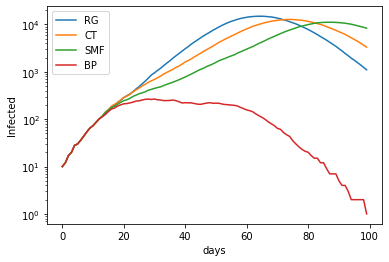

In [8]:
%matplotlib inline
to_plot = "I"
for s in ress.keys():
    plt.plot(ress[s][to_plot], label = s)
plt.semilogy()
plt.ylabel("Infected")
plt.xlabel("days")
plt.legend()
plt.show()